In [69]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# import calculation libraries
from scipy.integrate import odeint
from scipy import integrate, optimize

# time libraries
import datetime
from datetime import datetime

In [107]:
def SEIR(y, t, beta, gamma1, gamma2, alpha, d1, r):
    #unpackage paraments
    S, E, I, R, total_death= y
    #S, E, I, R = y

    # calculte curve
    dS_dt = -beta*S*I*r/N
    dE_dt = beta*S*I*r/N - gamma1*E - alpha*E
    dI_dt = alpha*E - gamma2*I - d1*I
    dR_dt = gamma1*E + gamma2*I

    # the data we want to find
    total_death = d1*I
    #total_confirmed = alpha*E

    # return result
    return([dS_dt, dE_dt, dI_dt, dR_dt, total_death])
    
def fit_odeint(t,beta,gamma1,gamma2,alpha,d1,r):
    re = integrate.odeint(SEIR,[S0,E0,I0,R0,total_death],t,args=(beta,gamma1,gamma2,alpha,d1,r))
    return re[:,-1]

In [108]:
countries = ['Italy','Japan','China','United Kingdom','Spain','Iran','France','Germany']
dates = ['4/15/20','4/16/20','4/17/20','4/18/20','4/19/20','4/20/20','4/21/20','4/22/20','4/23/20','4/24/20','4/25/20','4/26/20','4/27/20','4/28/20','4/29/20','4/30/20','5/1/20']

In [109]:
# load data
confirmed_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
deaths_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
country_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')

In [110]:
country_pop = country_pop.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'})
deaths_data = deaths_data.rename(columns={'Province/State':'State','Country/Region':'Country'})
confirmed_data = confirmed_data.rename(columns={'Province/State':'State','Country/Region':'Country'})

In [74]:
re = {}
result_data = {}

In [175]:
country = 'China'
# get N
population = country_pop.loc[country_pop['Country']==country,'Population']
N = population.iloc[0]

# deaths data
deaths_data_copy = deaths_data.loc[deaths_data['Country']==country]
deaths = deaths_data_copy.iloc[:,4:].sum(axis = 0)

In [176]:
deaths

1/22/20      17
1/23/20      18
1/24/20      26
1/25/20      42
1/26/20      56
           ... 
4/10/20    3340
4/11/20    3343
4/12/20    3343
4/13/20    3345
4/14/20    3345
Length: 84, dtype: int64

In [272]:
y_data = [max(i,17) for i in range(40)]
for value in deaths.values:
    y_data.append(value)
#y_data = deaths.values
x_data = [i+1 for i in range(len(y_data))]

In [273]:
print(len(x_data))

124


In [301]:
min_diff = 9999999

for E0 in range(2000,20001,20):
    I0 = 0
    S0 = N - I0 - E0 # inital Susceptible

    # other parameters
    R0 = 0 # inital recovered
    total_death = 0
    total_confirmed = I0

    y = S0,E0,I0,R0,total_death

    # fitting
    popt, pcov = optimize.curve_fit(fit_odeint, x_data, y_data,maxfev=5000)
    fitted = fit_odeint(x_data, *popt)

    # calculte diff
    diff = 0
    for i in range(len(x_data)):
        diff += abs(fitted[-i]-fitted[-i-1]-y_data[-i]+y_data[-i-1])
        #diff += abs(fitted[i]-y_data[i])*i
    if diff < min_diff:
        min_diff = diff
        re[country] = [popt] + [E0] + [I0]



print(E0,I0)
print(country+' is Complete!')

20000 0
China is Complete!


In [302]:
#predict
popt = re[country][0]
E0 = re[country][1]
I0 = re[country][2]

t = [i+1 for i in range(len(x_data)+17)]
t = np.array(t)
fitted2 = fit_odeint(t, *popt)
fitted = fit_odeint(x_data, *popt)


In [303]:
result_data[country] = [[x_data, y_data], # actual data
                        [x_data, fitted], # fitted data
                        [t, fitted2], # prediction data
                        [popt, E0, I0]] # parameters

In [304]:
print(popt)
print(E0,I0)
# beta, gamma1, gamma2, alpha, d1, r

[1.4574479  0.96946332 0.91648641 0.7380026  0.0141184  1.45752491]
10500 0


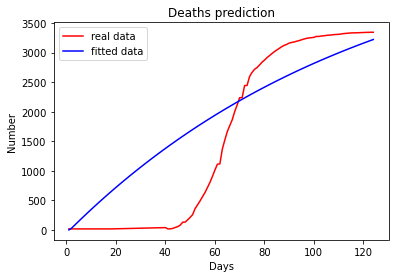

In [305]:
data = result_data['China']
x_data, y_data = data[0]
x_data, fitted = data[1]
t, fitted2 = data[2]
plt.plot(x_data, y_data, color = 'r',label='real data')
plt.plot(x_data, fitted, color = 'b',label='fitted data')

#plt.plot(t, fitted2, color = 'yellow')

plt.title("Deaths prediction")
plt.ylabel("Number")
plt.xlabel("Days")
plt.legend()
plt.show()

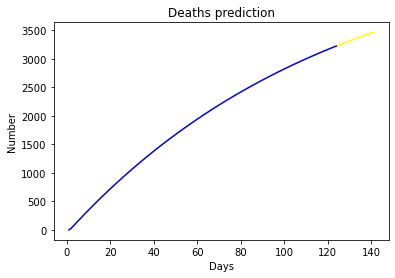

In [306]:
fitted2 = fit_odeint(t, *popt)
fitted = fit_odeint(x_data, *popt)
plt.plot(t, fitted2, color = 'yellow')
plt.plot(x_data, fitted, color = 'b')

plt.title("Deaths prediction")
plt.ylabel("Number")
plt.xlabel("Days")
plt.show()

In [307]:
print(fitted2[-1])
print(fitted[-1])
print(y_data[-1])

3462.9803412465153
3221.9460463015785
3345


In [308]:
x_data = x_data[40:]
y_data = y_data[40:]
fitted1 = fitted1[40:]
fitted2 = fitted2[40:]
t = t[40:]

In [314]:
len(fitted1)

74

In [311]:
result_data[country] = [[x_data, y_data], # actual data
                        [x_data, fitted1], # fitted data
                        [t, fitted2], # prediction data
                        [popt, E0, I0]] # parameters

In [312]:
len(fitted2)

101

In [313]:
import pickle
with open('../data/China_prediction','wb') as f:
    pickle.dump(result_data,f)